# Personalized Medicine Predictive Modeling Workflow
Goal: Predict whether a variant is associated with a drug response or phenotype based on high-confidence clinical annotations from PharmGKB.

## Set up the environment

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

## Load the TSV File
Load the PharmGKB clinical variant-drug data. (https://www.clinpgx.org/downloads) 

In [3]:
# Load the TSV file
df = pd.read_csv("clinical_variants.tsv", sep="\t")

# Quick overview
print("Initial shape:", df.shape)
df.head()

Initial shape: (5190, 6)


,variant,gene,type,level of evidence,chemicals,phenotypes
0,"CYP2C9*1, CYP2C9*3, CYP2C9*13",CYP2C9,Metabolism/PK,1A,lornoxicam,NaN
1,"CYP2C9*1, CYP2C9*2, CYP2C9*3",CYP2C9,Metabolism/PK,1A,siponimod,NaN
2,rs17376848,DPYD,Toxicity,1A,capecitabine,Neoplasms
3,rs2297595,DPYD,Toxicity,1A,capecitabine,Neoplasms
4,rs1801265,DPYD,Toxicity,1A,capecitabine,Neoplasms


In [4]:
# Inspect the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5190 entries, 0 to 5189
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   variant            5190 non-null   object
 1   gene               4936 non-null   object
 2   type               5190 non-null   object
 3   level of evidence  5190 non-null   object
 4   chemicals          5190 non-null   object
 5   phenotypes         4176 non-null   object
dtypes: object(6)
memory usage: 243.4+ KB


## Clean the dataset

**Standardize columns and values**

In [5]:
# Remove leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Standardize string columns
string_cols = ['variant', 'gene', 'type', 'level of evidence', 'chemicals', 'phenotypes']
for col in string_cols:
    df[col] = df[col].astype(str).str.strip()

# Convert string "nan" or "NaN" to actual np.nan
df.replace({'nan': np.nan, 'NaN': np.nan}, inplace=True)

**Handle Missing Values**

In [7]:
# Drop rows missing critical info
df = df.dropna(subset=['variant', 'chemicals'])
print("After dropping rows missing variant or chemical:", df.shape)

# Fill missing gene values
df['gene'] = df['gene'].fillna('Unknown')

# Remove duplicates
df = df.drop_duplicates()
print("After removing duplicates:", df.shape)

After dropping rows missing variant or chemical: (5190, 6)
After removing duplicates: (5169, 6)


**Create a binary target**

In [8]:
# Create a binary target: 1 if phenotype exists, 0 if not
df['phenotype_present'] = df['phenotypes'].notna().astype(int)

# Check target distribution
print("Target distribution:\n", df['phenotype_present'].value_counts())

Target distribution:
 phenotype_present
1    4163
0    1006
Name: count, dtype: int64


**Quick Exploratory Checks**

In [9]:
print("Number of unique drugs:", df['chemicals'].nunique())
print("Number of unique variants:", df['variant'].nunique())
print("Number of unique genes:", df['gene'].nunique())
print("Number of unique evidence levels:", df['level of evidence'].nunique())

Number of unique drugs: 874
Number of unique variants: 3161
Number of unique genes: 1088
Number of unique evidence levels: 6


**Observations:**
1. Target imbalance

- Most rows have phenotype_present = 1.

- I will need to handle class imbalance in my predictive models (e.g., using class_weight='balanced' or oversampling/undersampling).

2. High dimensionality

- 3161 unique variants means my feature matrix will be large. One-hot encoding SNPs will produce many columns.

3. Multiple drugs

- 874 unique drugs suggest that modeling per drug may not be feasible due to sparse data for each.

- You can either:
    - Model all drugs together with “drug” as a feature, or
    - Focus on top N drugs with enough samples.

4. Evidence levels

- Can be used as categorical features if desired.

## Exploratory Data Analysis (EDA)

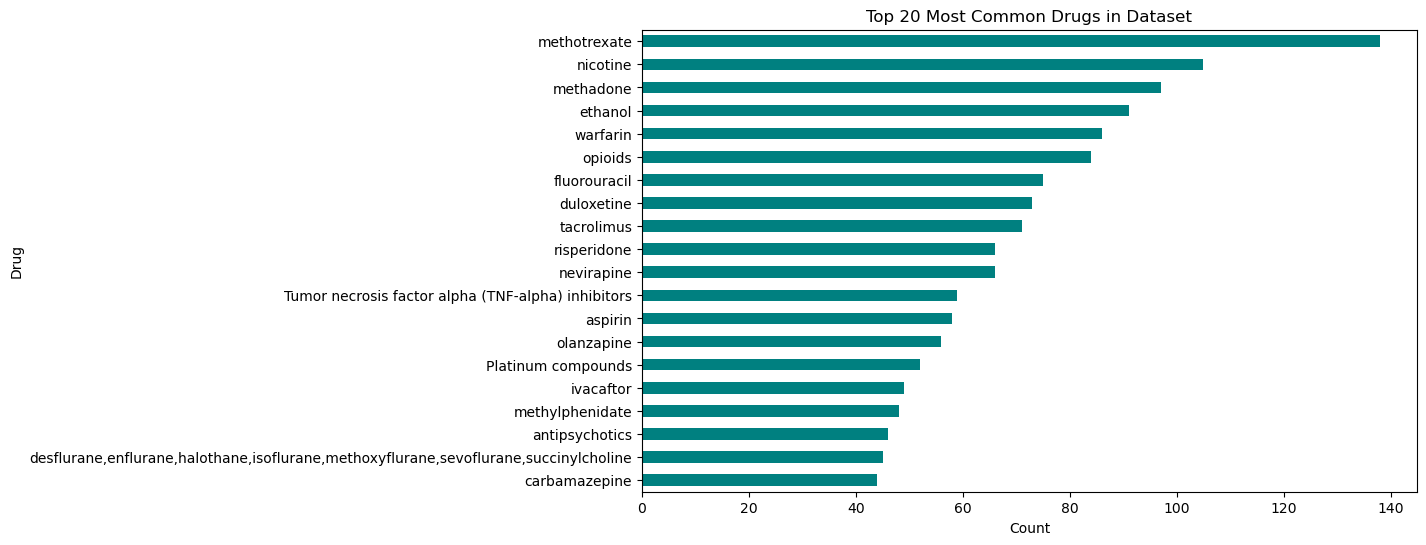

In [86]:
# Top 20 drugs
plt.figure(figsize=(10,6))
df["chemicals"].value_counts().head(20).plot(kind='barh', color='teal')
plt.gca().invert_yaxis()
plt.title("Top 20 Most Common Drugs in Dataset")
plt.xlabel("Count")
plt.ylabel("Drug")
plt.show()

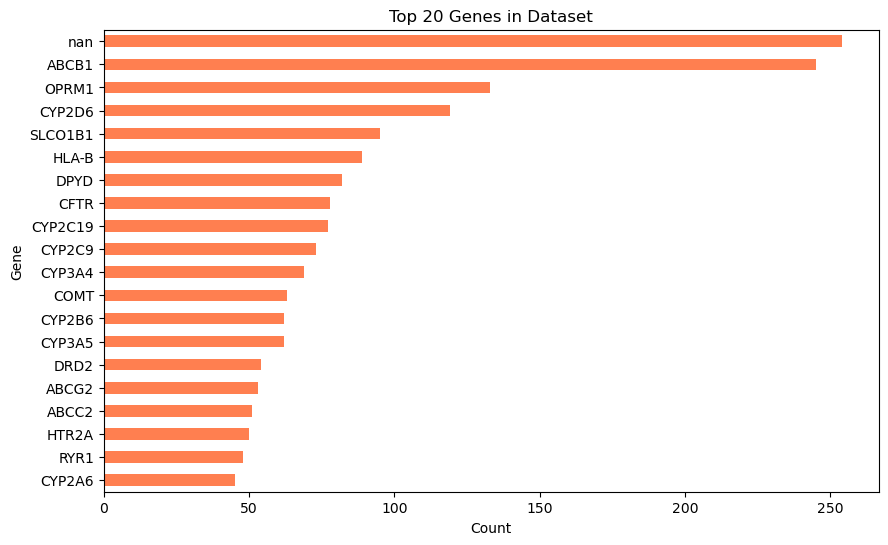

In [87]:
# Top 20 genes
plt.figure(figsize=(10,6))
df["gene"].value_counts().head(20).plot(kind='barh', color='coral')
plt.gca().invert_yaxis()
plt.title("Top 20 Genes in Dataset")
plt.xlabel("Count")
plt.ylabel("Gene")
plt.show()

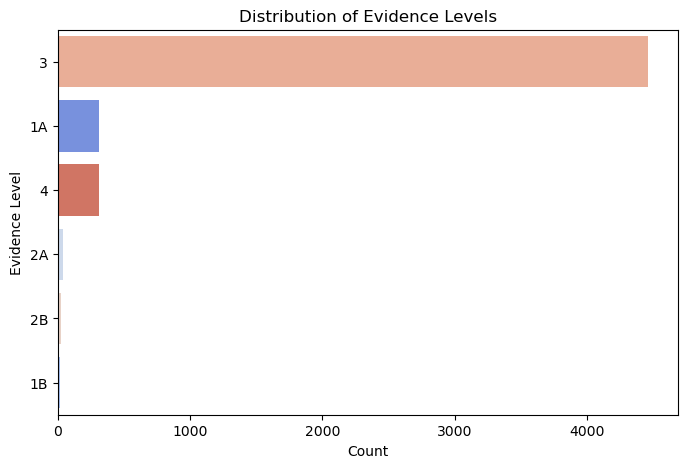

In [88]:
# Evidence level distribution
plt.figure(figsize=(8,5))
sns.countplot(
    y='level of evidence',
    data=df,
    order=df['level of evidence'].value_counts().index,
    hue='level of evidence',
    palette='coolwarm',
    legend=False
)
plt.title("Distribution of Evidence Levels")
plt.xlabel("Count")
plt.ylabel("Evidence Level")
plt.show()

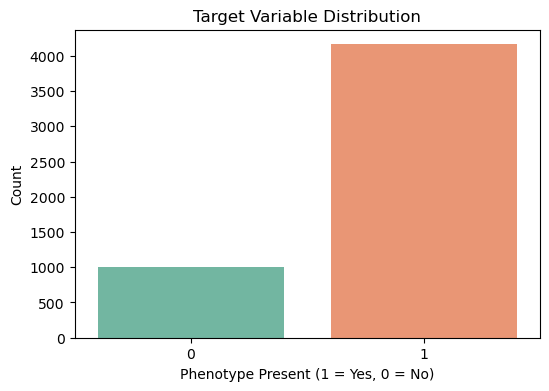

In [90]:
# Target variable distribution
plt.figure(figsize=(6,4))
sns.countplot(
    x='phenotype_present',
    data=df,
    hue='phenotype_present',
    palette='Set2',
    legend=False
)
plt.title("Target Variable Distribution")
plt.xlabel("Phenotype Present (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()

## Prepare Feature Matrix (X) and (y)

In [93]:
# Binary target
y = df['phenotype_present']

# One-hot encode variants
variants = df['variant'].str.get_dummies(sep=', ')

# Include gene, type, level of evidence
categorical_features = pd.get_dummies(df[['gene', 'type', 'level of evidence']], drop_first=True)

# Combine features
X = pd.concat([variants, categorical_features], axis=1)

print("Feature matrix shape:", X.shape)
print("Target distribution:\n", y.value_counts())

Feature matrix shape: (5169, 4412)
Target distribution:
 phenotype_present
1    4163
0    1006
Name: count, dtype: int64


## Train-Test Split

In [94]:
# Split with stratification on target to preserve class balance
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Split temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (3618, 4412)
Validation shape: (775, 4412)
Test shape: (776, 4412)


## Modeling
### Linear Regression

In [95]:
# Initialize Logistic Regression with balanced class weight
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)

# Predict
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:,1]

# Evaluate
print("--- Logistic Regression ---")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr))
print(classification_report(y_test, y_pred_lr))

--- Logistic Regression ---
Accuracy: 0.8170103092783505
ROC AUC: 0.8299496688741721
              precision    recall  f1-score   support

           0       0.52      0.70      0.60       151
           1       0.92      0.84      0.88       625

    accuracy                           0.82       776
   macro avg       0.72      0.77      0.74       776
weighted avg       0.84      0.82      0.83       776



### Random Forest

In [96]:
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("--- Random Forest ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))
print(classification_report(y_test, y_pred_rf))

--- Random Forest ---
Accuracy: 0.8221649484536082
ROC AUC: 0.8292185430463577
              precision    recall  f1-score   support

           0       0.54      0.53      0.54       151
           1       0.89      0.89      0.89       625

    accuracy                           0.82       776
   macro avg       0.72      0.71      0.71       776
weighted avg       0.82      0.82      0.82       776



### Feature Importance (Random Forest Example)

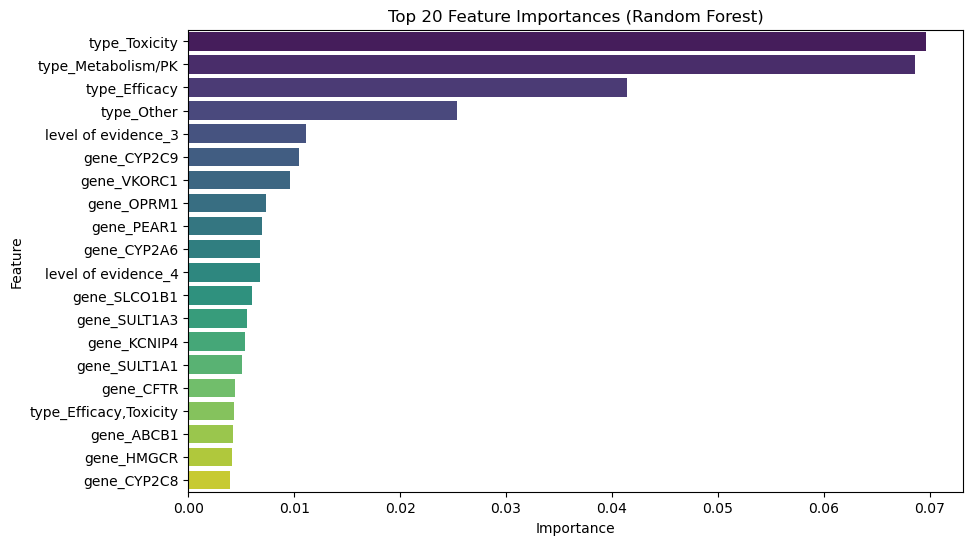

In [99]:
# Top 20 important features
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
top_features = feature_importances.head(20)

plt.figure(figsize=(10,6))
sns.barplot(
    x=top_features.values,
    y=top_features.index,
    hue=top_features.index,   # map palette to features
    palette='viridis',
    dodge=False,
    legend=False               # hide redundant legend
)
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

**Logistic Regression**

- Accuracy: 0.82 → Overall, the model correctly predicts ~82% of cases.
- ROC AUC: 0.83 → Good discriminative ability between responders and non-responders.
- Class 0 (non-responder):
    - Precision 0.52, Recall 0.70 → The model correctly identifies 70% of actual non-responders but also has some false positives.
- Class 1 (responder):
    - Precision 0.92, Recall 0.84 → Most responders are correctly identified, with high precision.

**Random Forest**

- Accuracy: 0.82 → Similar to Logistic Regression.
- ROC AUC: 0.83 → Also strong.
- Class 0 (non-responder):
    - Precision 0.54, Recall 0.53 → Slightly worse recall than LR for non-responders.
- Class 1 (responder):
    - Precision 0.89, Recall 0.89 → Balanced detection for responders.

**Observations**

- Both models handle the class imbalance reasonably well (using class_weight='balanced').
- Logistic Regression has slightly better recall for non-responders, Random Forest slightly better for responders.
- Overall, ROC AUCs are strong, indicating that your features (variants + gene/type/evidence) are predictive.
